# Étude statistique sur la corrélation entre les données météorologiques et la consommation électrique en France en 2025

**Membres du groupe** :
- Célian Aldehuelo Mateos
- Martin Kanounnikoff
- Nicolas Bureau-Maury
- Théo Hénon

**Objectif** : Étudier la corrélation entre la température et la consommation électrique en France en 2025 à l'aide de tests statistiques. Sachant que la notion de "température" sera divisée en deux définitions : la température réelle $T_{réelle}$ et la température ressentie $T_{ressentie}$.

Une première partie se concentrera donc sur l'étude de la corrélation entre la température réelle $T_{réelle}$ et la consommation électrique $E$, et une seconde partie sur la corrélation entre la température ressentie $T_{ressentie}$ et la consommation électrique $E$.

Importations des bibliothèques nécéssaires :

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import requests
import logging
import time
import os
import math

## 1 Importation et traitement des données

Nous avons récupérées les données suivantes :
- Les données météorologiques de [Météo France](https://www.data.gouv.fr/datasets/donnees-climatologiques-de-base-quotidiennes) pour l'année 2025
- Les données de [consommation électrique de RTE](https://www.services-rte.com/fr/telechargez-les-donnees-publiees-par-rte.html?category=consumption&type=short_term) pour l'année 2025

### 1.1 Données météorologiques

Pour récupérer les données de Météo France, il est nécéssaire de communiquer avec l'API. Pour se faciliter le travail, nous avons développer un *data scrapper* pour récupérer les tables de données et construire un **dataframe**.

In [41]:
class DataGouvFrScrapper:
    def __init__(self, dataset_id: str, timeout: int, max_retries: int, sleep_between_retries: float, path: str = "./data/meteofrance"):
        self.dataset_id = dataset_id
        self.timeout = timeout
        self.max_retries = max_retries
        self.sleep_between_retries = sleep_between_retries
        self.infos = None
        self.resources = []
        self.path = path

    def _get_api_url(self) -> str:
        return f"https://www.data.gouv.fr/api/1/datasets/{self.dataset_id}/"

    def _fetch_dataset_infos(self, force = False) -> None:
        if not force and self.infos is not None:
            return

        url = self._get_api_url()
        attempt = 0
        logging.info(f"Fetching dataset infos from {url}")
        while attempt < self.max_retries:
            try:
                response = requests.get(url, timeout=self.timeout)
                response.raise_for_status()
                self.infos = response.json()
                return
            except requests.RequestException as e:
                logging.error(f"Attempt {attempt + 1} failed: {e}")
                attempt += 1
                if attempt < self.max_retries:
                    time.sleep(self.sleep_between_retries)
        raise Exception("Max retries exceeded")

    def _fetch_resources(self, force = False) -> list:
        if not force and len(self.resources) > 0:
            return self.resources

        if self.infos is None:
            self._fetch_dataset_infos()

        self.resources = self.infos.get("resources", [])
        return self.resources

    def _download_resources(self, force=False, filter=None) -> None:
        resources = self._fetch_resources(force=force)
        os.makedirs(self.path, exist_ok=True)

        for resource in resources:
            resource_url = resource.get("url")

            if filter is not None and filter(resource_url) is None:
                logging.info(f"Resource \"{resource_url}\" filtered out, skipping download.")
                continue

            filename = os.path.join(self.path, resource_url.split("/")[-1])
            if os.path.exists(filename):
                logging.info(f"File \"{filename}\" already exists, skipping download.")
                continue

            logging.info(f"Fetching resource \"{resource_url}\"")
            attempt = 0
            while attempt < self.max_retries:
                try:
                    response = requests.get(resource_url, timeout=self.timeout)
                    response.raise_for_status()
                    with open(filename, "wb") as f:
                        f.write(response.content)
                    break
                except requests.RequestException as e:
                    logging.error(f"Attempt {attempt + 1} to download {resource_url} failed: {e}")
                    attempt += 1
                    if attempt < self.max_retries:
                        time.sleep(self.sleep_between_retries)
            else:
                logging.error(f"Failed to download resource {resource_url} after {self.max_retries} attempts.")

    def build_dataframe(self, force=False, filter=None) -> dict[str, pd.DataFrame]:
        self._download_resources(force=force, filter=filter)

        filepaths = [os.path.join(self.path, f) for f in os.listdir(self.path) if f.endswith(".csv.gz")]

        def dataframe_generator(expected_category: str):
            for filepath in filepaths:
                category = filter(filepath) if filter is not None else "default"
                if category == expected_category:
                    yield pd.read_csv(filepath, compression='gzip', sep=';')

        categories: set[str] = set()
        if filter is None:
            categories.add("default")
        else:
            for filepath in filepaths:
                categories.add(filter(filepath))

        data_by_category: dict[str, pd.DataFrame] = dict()
        for expected_category in categories:
            concatenated = pd.concat(dataframe_generator(expected_category), ignore_index=True)
            if len(concatenated) > 0:
              data_by_category[expected_category] = concatenated

        return data_by_category

On initialise le scrapper comme suit :

In [42]:
scrapper = DataGouvFrScrapper(
    dataset_id="6569b51ae64326786e4e8e1a",
    timeout=30,
    max_retries=4,
    sleep_between_retries=2.5,
    path="./data/meteofrance"
)

On scrap les données filtrées (celles provenant de 2025-2026 et les données météorologiques, ainsi que descriptif des champs des tables de données). On construit un dataframe comme suit :

In [43]:
def meteofrance_resource_filter(url: str) -> str:
    if "2025-2026" in url:
        if "RR-T-Vent" in url:
            if "descriptif_champs" in url:
                return "descriptif"
            else:
                return "rr-t-vent"
        if "autres-parametres" in url:
            if "descriptif_champs" in url:
                return "descriptif"
            else:
                return "autres-parametres"
    return None

meteofrance_datasets = scrapper.build_dataframe(filter=meteofrance_resource_filter)

meteofrance_df = meteofrance_datasets["rr-t-vent"]
meteofrance_extra_df = meteofrance_datasets["autres-parametres"]

In [44]:
meteofrance_df.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,89003001,AILLANT,47.874,3.353667,124,20250101,1.0,1.0,-2.3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89003001,AILLANT,47.874,3.353667,124,20250102,19.1,1.0,1.3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89003001,AILLANT,47.874,3.353667,124,20250103,0.2,1.0,-2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89003001,AILLANT,47.874,3.353667,124,20250104,12.3,1.0,-6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89003001,AILLANT,47.874,3.353667,124,20250105,0.2,1.0,0.9,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ensuite on utilise cette table pour récupérer la **température nationale quotidienne**. Ensuite on en calcul la **moyenne nationale** :

In [45]:
meteofrance_extra_df['U'] = (meteofrance_extra_df['UN'] + meteofrance_extra_df['UX']) / 2

meteo_by_day = (
    meteofrance_df
    .assign(date=pd.to_datetime(meteofrance_df['AAAAMMJJ'].astype(str), format='%Y%m%d'))
    .groupby('date', sort=True)
)

meteo_extra_by_day = (
    meteofrance_extra_df
    .assign(date=pd.to_datetime(meteofrance_df['AAAAMMJJ'].astype(str), format='%Y%m%d'))
    .groupby('date', sort=True)
)

temp_national_quotidienne = (
    meteo_by_day['TM']
    .mean()
    .reset_index(name='TM_mean')
)

humidity_by_day = (
    meteo_extra_by_day['U']
    .mean()
    .reset_index(name='U_mean')
)['U_mean']

wind_speed_by_day = (
    meteo_by_day['FFM']
    .mean()
    .reset_index(name='FFM_mean')
)['FFM_mean']

### 1.2 Données de consommation électrique

On récupère les données de consommation électrique depuis un fichier csv téléchargé préalablement.

In [46]:
rte_df = pd.read_csv("./data/rte/conso_mix_consolidated.csv", sep=",")

In [47]:
rte_df.head()

,date,Heures,PrévisionJ-1,PrévisionJ,Consommation
0,2025-01-01,00:00,57711.0,63667.0,64354.0
1,2025-01-01,00:15,57122.0,64233.0,64521.0
2,2025-01-01,00:30,62700.0,63100.0,63715.0
3,2025-01-01,00:45,62700.0,63100.0,62502.0
4,2025-01-01,01:00,61100.0,61300.0,61490.0


<Axes: title={'center': 'Consommation moyenne nationale quotidienne'}, xlabel='Date', ylabel='Consommation (MWh)'>

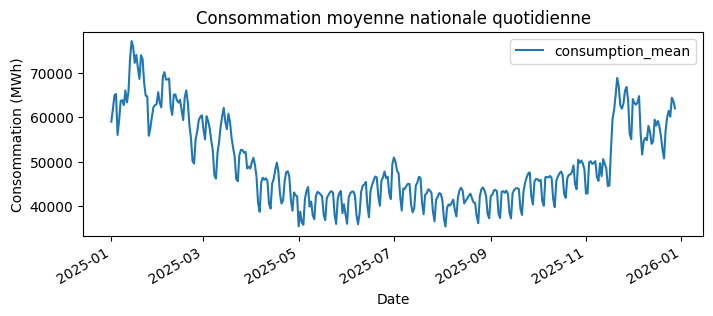

In [48]:
per_day_consumption = (
    rte_df
    .assign(date=pd.to_datetime(rte_df['date'], format='%Y-%m-%d'))
    .groupby('date', sort=True)['Consommation']
    .mean()
    .reset_index(name='consumption_mean')
)

per_day_consumption.plot(x='date', y='consumption_mean', title='Consommation moyenne nationale quotidienne', ylabel='Consommation (MWh)', xlabel='Date', figsize=(8, 3))

### 1.3 Lissage des données

In [49]:
# Lissage par filtre gaussien
def smooth_gausian(data: np.ndarray, radius: int) -> np.ndarray:
  sigma = radius / 2
  return sp.ndimage.gaussian_filter1d(data, sigma, mode='reflect')

# Lissage par moyenne sur fenettre glissante
def smooth_average(data: np.ndarray, radius: int) -> np.ndarray:
  window_width = 2 * radius + 1
  return np.convolve(data, np.ones((window_width,), dtype=np.float32) / window_width, mode='valid')

In [50]:
consumption = per_day_consumption['consumption_mean']
temperature = temp_national_quotidienne['TM_mean']
wind_speed = wind_speed_by_day
humidity = humidity_by_day

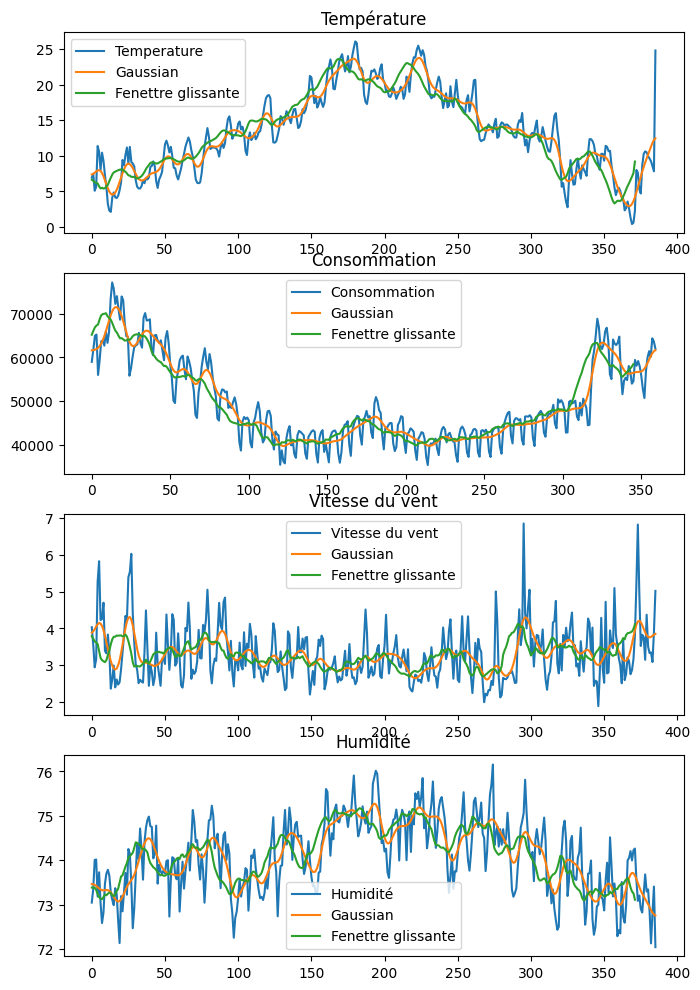

In [51]:
# ====== Lissage des données ======

radius = 7

# Gaussian smooth
smoothed_temperature = smooth_gausian(temperature, radius)
smoothed_consumption = smooth_gausian(consumption, radius)
smoothed_wind_speed = smooth_gausian(wind_speed, radius)
smoothed_humidity = smooth_gausian(humidity, radius)

# Sliding window average
avg_smoothed_temperature = smooth_average(temperature, radius)
avg_smoothed_consumption = smooth_average(consumption, radius)
avg_smoothed_wind_speed = smooth_average(wind_speed, radius)
avg_smoothed_humidity = smooth_average(humidity, radius)

# Plot into 4 subplot
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].plot(temperature, label='Temperature')
axs[0].plot(smoothed_temperature, label='Gaussian')
axs[0].plot(avg_smoothed_temperature, label='Fenettre glissante')
axs[0].legend()
axs[0].set_title('Température')

axs[1].plot(consumption, label='Consommation')
axs[1].plot(smoothed_consumption, label='Gaussian')
axs[1].plot(avg_smoothed_consumption, label='Fenettre glissante')
axs[1].legend()
axs[1].set_title('Consommation')

axs[2].plot(wind_speed, label='Vitesse du vent')
axs[2].plot(smoothed_wind_speed, label='Gaussian')
axs[2].plot(avg_smoothed_wind_speed, label='Fenettre glissante')
axs[2].legend()
axs[2].set_title('Vitesse du vent')

axs[3].plot(humidity, label='Humidité')
axs[3].plot(smoothed_humidity, label='Gaussian')
axs[3].plot(avg_smoothed_humidity, label='Fenettre glissante')
axs[3].legend()
axs[3].set_title('Humidité')

plt.show()

## 2 Analyse de la loi de la température et de la consomation électrique

### 2.1 Regression vers une courbe de cosinus surélevé

On cherche maintenant à estimer la **température** et la **consommation** annuelle en utilisant la **régression vers une courbe de cosinus surélevé**. L'avantage de cette méthode est la partie cyclique du cosinus qui permet de revenir à la même valeur après une année complète

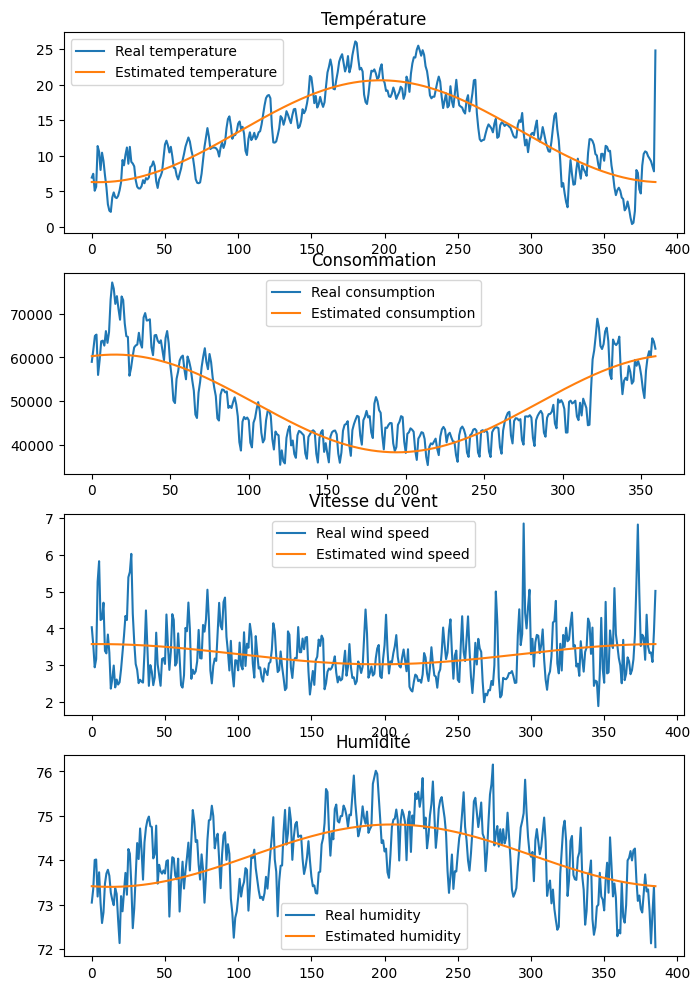

In [52]:
def find_best_elaveted_cos(data: np.ndarray, elevation = 1, scale = 1, phase = 0) -> np.ndarray:
  def elaveted_cos(x: np.ndarray, elevation, scale, phase) -> np.ndarray:
      return np.cos((x * 2 - 1) * math.pi + phase) * scale + elevation

  x = np.linspace(0, 1, data.shape[0])
  popt, _ = sp.optimize.curve_fit(elaveted_cos, x, data, [elevation, scale, phase])

  return elaveted_cos(x, *popt)

estimated_temperature = find_best_elaveted_cos(temperature, elevation = 1, scale = 1)
estimated_consumption = find_best_elaveted_cos(consumption, elevation = 1, scale = -1)
estimated_wind_speed = find_best_elaveted_cos(wind_speed, elevation = 1, scale = 1)
estimated_humidity = find_best_elaveted_cos(humidity, elevation = 1, scale = 1)

# Plot regressed vs real curves into 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].plot(temperature, label='Real temperature')
axs[0].plot(estimated_temperature, label='Estimated temperature')
axs[0].legend()
axs[0].set_title('Température')

axs[1].plot(consumption, label='Real consumption')
axs[1].plot(estimated_consumption, label='Estimated consumption')
axs[1].legend()
axs[1].set_title('Consommation')

axs[2].plot(wind_speed, label='Real wind speed')
axs[2].plot(estimated_wind_speed, label='Estimated wind speed')
axs[2].legend()
axs[2].set_title('Vitesse du vent')

axs[3].plot(humidity, label='Real humidity')
axs[3].plot(estimated_humidity, label='Estimated humidity')
axs[3].legend()
axs[3].set_title('Humidité')

plt.show()

### 2.2 Test de normalité

Une fois l'estimation par **Regression vers une courbe de cosinus surélevé** faite, il faut désormais **tester la normalité** des erreurs entre la valeur estimée et la valeur réelle de la **température** et de la **consommation**.

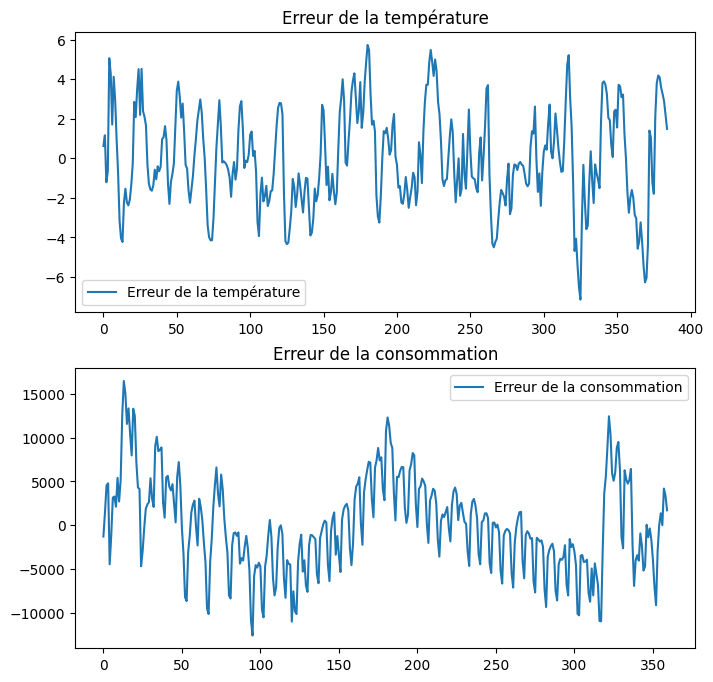

In [53]:
# Test de normalité sur la température et la consommation
estimated_vs_real_temperature_error = temperature - estimated_temperature
estimated_vs_real_consumption_error = consumption - estimated_consumption

estimated_vs_real_temperature_error = estimated_vs_real_temperature_error[np.abs(estimated_vs_real_temperature_error) < 10]
estimated_vs_real_consumption_error = estimated_vs_real_consumption_error[np.abs(estimated_vs_real_consumption_error) < 20000]

# Plot errors lines into 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(estimated_vs_real_temperature_error, label='Erreur de la température')
axs[0].legend()
axs[0].set_title('Erreur de la température')

axs[1].plot(estimated_vs_real_consumption_error, label='Erreur de la consommation')
axs[1].legend()
axs[1].set_title('Erreur de la consommation')

plt.show()

**2.2.1 Test de D'Agostino K2**

Le test de **D'Agostino K2** est utilisé pour déterminer si une distribution est **normale**. Il est basé sur la mesure de l'asymétrie et de l'aplatissement de la distribution. Une p-value supérieure à un seuil donné (généralement 0.05) indique que l'on ne peut pas rejeter l'hypothèse de normalité, suggérant que les données sont normalement distribuées. Dans le cas contraire, on rejette l'hypothèse de normalité.


In [54]:
# D'Agostino K2 test température
k2_stat, k2_p = sp.stats.normaltest(estimated_vs_real_temperature_error)
print(f"D'Agostino K2 stat={k2_stat:.4f}, p-value={k2_p:.4g}")

D'Agostino K2 stat=2.7597, p-value=0.2516


Ici, la p-value est de `0.2516`, ce qui est supérieur à `0.05`. Cela indique que nous ne pouvons pas rejeter l'hypothèse que la température moyenne nationale hebdomadaire suit une distribution normale.

In [55]:
# D'Agostino K2 test consomation
k2_stat, k2_p = sp.stats.normaltest(estimated_vs_real_consumption_error)
print(f"D'Agostino K2 stat={k2_stat:.4f}, p-value={k2_p:.4g}")

D'Agostino K2 stat=4.0504, p-value=0.132


Même conclusion pour la consommation, la p-value de `0.132` > `0.05` indique que l'hypothèse n'est pas rejetable.

**2.2.2 Test de Shapiro-Wilk**

Le **test de Shapiro-Wilk** est un autre test de normalité qui évalue si un échantillon de données provient d'une population normalement distribuée. A nouveau, Une p-value supérieure au seuil de signification (généralement 0.05) indique que nous ne pouvons pas rejeter l'hypothèse nulle, suggérant que les données suivent une distribution normale des erreurs.

In [56]:
# Shapiro-Wilk température
sh_stat, sh_p = sp.stats.shapiro(estimated_vs_real_temperature_error)
print(f"Shapiro-Wilk stat={sh_stat:.4f}, p-value={sh_p:.4g}")

Shapiro-Wilk stat=0.9899, p-value=0.009519


Cette fois, la p-value est de `0.009519` < `0.05` ce qui devrait rejeter l'hypothèse de normalité des erreurs mais au vu des résultats des tests suivants et précedents nous avons décidé d'ignorer ces résultats

In [57]:
# Shapiro-Wilk consommation
sh_stat, sh_p = sp.stats.shapiro(estimated_vs_real_consumption_error)
print(f"Shapiro-Wilk stat={sh_stat:.4f}, p-value={sh_p:.4g}")

Shapiro-Wilk stat=0.9934, p-value=0.1182


Pour la consommation, on retrouve une p-value de `0.1182` > `0.05` échouant à nouveau à rejeter l'hypothèse nulle de normalité des erreurs.

**2.2.3 QQ-Plot**

Nous avons aussi utilisé des **QQ-Plot** pour tester distribution normale.
Un **QQ-plot (Quantile-Quantile plot)** est un graphique qui compare la distribution des quantiles des données à la distribution des quantiles d'une distribution théorique (ici, une distribution normale). Si les points du QQ-plot suivent approximativement une ligne droite, cela suggère que les données sont normalement distribuées.

Dans le QQ-plot ci-dessous, les points s'alignent relativement bien le long de la ligne droite, ce qui visuellement soutient l'hypothèse de normalité pour la température et la  consommation moyenne nationale.

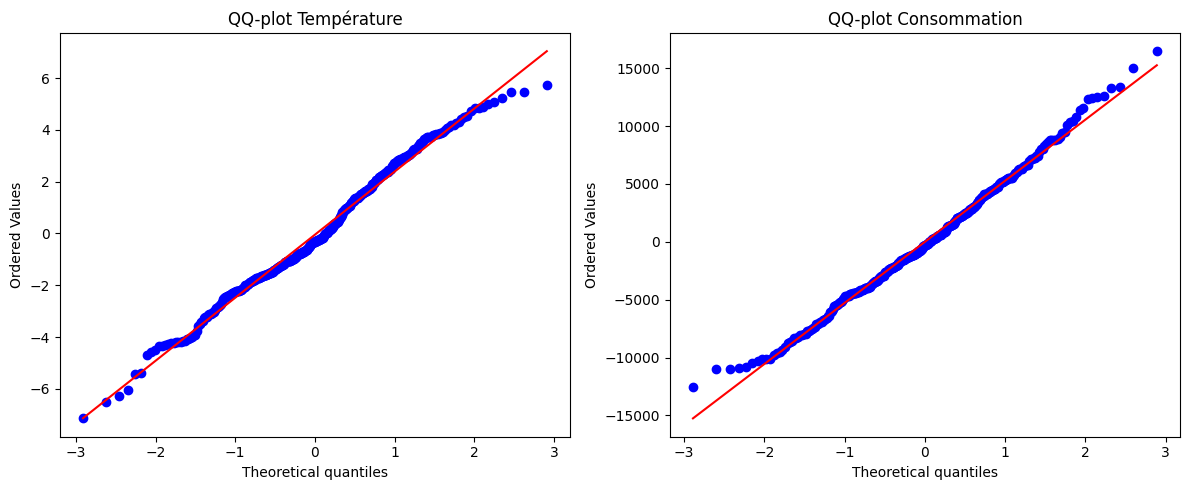

In [58]:
# QQ-plot température et consommation

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sp.stats.probplot(estimated_vs_real_temperature_error, dist="norm", plot=plt)
plt.title("QQ-plot Température")

plt.subplot(1, 2, 2)
sp.stats.probplot(estimated_vs_real_consumption_error, dist="norm", plot=plt)
plt.title("QQ-plot Consommation")

plt.tight_layout()
plt.show()

## 3 Analyse de la corrélation entre la **température réelle** et la consommation électrique

On souhaite tester la corrélation entre la température réelle et la consommation électrique journalière en France en 2025.
Pour cela on va simplement utiliser la température moyenne nationnale, ainsi que la consommation électrique moyenne.

Nous allons utiliser trois différents tests de corrélation :
1. Le test de corrélation de Pearson
2. Le test de corrélation de Spearman
3. Le test de corrélation de Kendall $\tau$

Notre hypothèse est qu'**il n'existe pas de corrélation** entre la température réelle $T^{réel}$ et la consommation électrique $E^{réel}$, c'est à dire :

$H_0 : \rho = 0$ et $H_1 : \rho \neq 0$

avec $\rho$ le coefficient de corrélation.

### 3.1 Test de corrélation de Pearson

Le test de corrélation de Pearson permet de mesurer si deux séries de données sont linéairement corrélés. Le coefficient de corrélation de Pearson $\rho$ est calculé comme suit :
$\rho = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$

avec : $X = T^{réelle}$ et $Y = E^{réelle}$

Ce test nécéssite que l'erreur sur X et Y suive **une loi normale**, ce qui a été **vérifié précédemment** avec les tests de Shapiro-Wilk et de D'Agostino K2

In [59]:
x, y = temperature, consumption
x.shape, y.shape

((386,), (360,))

In [60]:
x_clean, y_clean = x[:360], y[:360]
x_clean.shape, y_clean.shape

((360,), (360,))

In [61]:
pearson_corr, pearson_p = sp.stats.pearsonr(x_clean, y_clean)
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4g}")

Pearson correlation: -0.7959, p-value: 4.905e-80


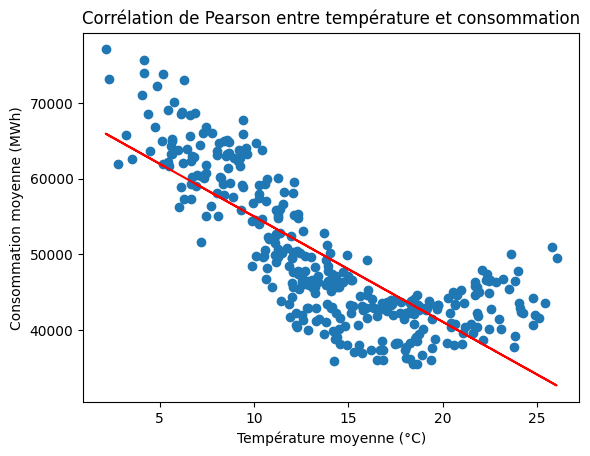

In [62]:
coef = np.polyfit(x_clean, y_clean, 1)
poly = np.poly1d(coef)

plt.figure()
plt.scatter(x_clean, y_clean)
plt.plot(x_clean, poly(x_clean), color='red')
plt.xlabel("Température moyenne (°C)")
plt.ylabel("Consommation moyenne (MWh)")
plt.title("Corrélation de Pearson entre température et consommation")
plt.show()

On remarque que le coefficient de corrélation de Pearson est de **$-0.79$**, ce qui indique une **forte corrélation négative** entre la température réelle et de la consommation électrique.

La valeur de **p-value est inférieure à $0.05$**, ce qui nous permet de **rejeter l'hypothèse nulle $H_0$ au seuil $5\%$**. Nous pouvons donc conclure qu'il existe une corrélation significative entre la température réelle et de la consommation électrique en France en 2025 selon le **test de Pearson**.

De plus, nous pouvons visualiser cette corrélation à l'aide d'un nuage de points avec une **droite de régression linéaire**.

### 3.2 Test de corrélation de Spearman

Le test de corrélation de Spearman mesure la corrélation monotone entre deux séries de données $X$ et $Y$. Le coefficient de corrélation de Spearman $\rho$ est calculé en utilisant les rangs des données plutôt que les valeurs brutes, et vaut :

$\rho = \frac{cov(rg_X, rg_Y)}{\sigma_{rg_X} \sigma_{rg_Y}}$

avec :
- $X = T^{réel}$ et $Y = E^{réel}$
- $rg_X$, $rg_Y$ les rangs de $X$ et $Y$ respectivement

In [63]:
spearman_corr, spearman_p = sp.stats.spearmanr(x_clean, y_clean)
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4g}")

Spearman correlation: -0.7978, p-value: 1.114e-80


On va représenter graphiquement les rangs de $T^{réel}$ et $E^{réel}$ pour visualiser la relation de monotonie entre les deux variables.

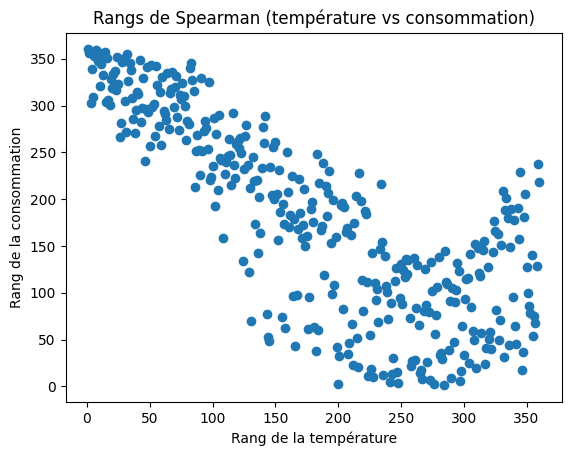

In [64]:
from scipy.stats import rankdata

x_rank = rankdata(x_clean)
y_rank = rankdata(y_clean)

plt.figure()
plt.scatter(x_rank, y_rank)
plt.xlabel("Rang de la température")
plt.ylabel("Rang de la consommation")
plt.title("Rangs de Spearman (température vs consommation)")
plt.show()

On remarque que le coefficient de corrélation de Spearman est de **$-0.
79$**, ce qui indique une **forte corrélation négative** entre la température réelle et la consommation électrique.

La valeur de **p-value est inférieure à $0.05$**, ce qui nous permet de **rejeter l'hypothèse nulle $H_0$ au seuil de confiance $95\%$**. Nous pouvons donc conclure qu'il existe une corrélation significative entre la température réelle et la consommation électrique en France en 2025 selon le **test de Spearman**.

De plus, nous pouvons visualiser :
- La **forte relation de monotonie pour des rangs $\lt 200$**, car les points sont proches de la droite $y=-x$. Cela signifie que pour des températures réelles relativement basses, la relation entre la température et la consommation électrique est prévisible.
- Au delà, la **relation de monotonie est moins évidente pour des rangs $\geq 200$**. Cela signifie que pour des températures réelles plus élevées, la relation entre la température et la consommation électrique devient moins prévisible.

On peut supposer que d'autres facteurs influencent la consommation électrique à des températures plus élevées, tels que l'utilisation accrue de la climatisation ou d'autres comportements liés à la chaleur.

### 3.3 Test de corrélation de Kendall $\tau$

In [65]:
kendalltau_corr, kendalltau_p = sp.stats.kendalltau(x_clean, y_clean)
print(f"Kendall Tau correlation: {kendalltau_corr:.4f}, p-value: {kendalltau_p:.4g}")

Kendall Tau correlation: -0.5987, p-value: 1.713e-64


On va représenter graphiquement les paires $(\Delta T, \Delta E)$ pour visualiser les paires concordantes et discordantes, en affichant 4 quadrants qui séparent les paires comme suit :
- Les paires concordantes se situent dans les quadrants II et IV (où les deux différences ont des signes opposé).
- Les paires discordantes se situent dans les quadrants I et III (soù les deux différences ont le même signe).
Dans chaque quadrant, on peut observer la répartition des paires de différences entre les valeurs de température réelle et de la consommation électrique.

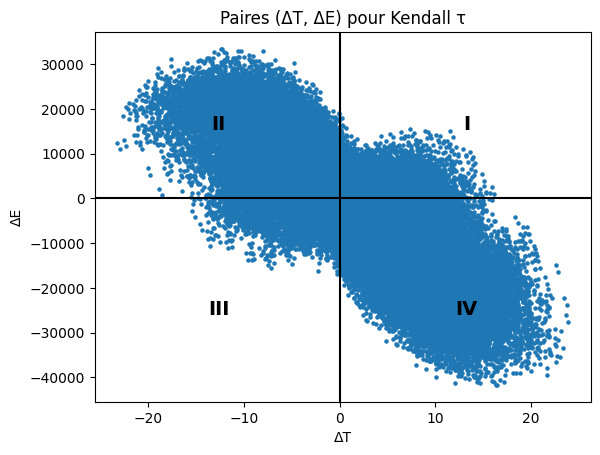

In [66]:
dT = []
dE = []

n = len(x_clean)
for i in range(n):
    for j in range(i+1, n):
        dT.append(x_clean[j] - x_clean[i])
        dE.append(y_clean[j] - y_clean[i])

dT = np.array(dT)
dE = np.array(dE)

plt.figure()
plt.scatter(dT, dE, s=5)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel("ΔT")
plt.ylabel("ΔE")
plt.title("Paires (ΔT, ΔE) pour Kendall τ")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
xmid = (xmin + xmax) / 2
ymid = (ymin + ymax) / 2
plt.text((xmid + xmax)/2, (ymid + ymax)/2, 'I', fontsize=14, weight='bold', ha='center', va='center')
plt.text((xmin + xmid)/2, (ymid + ymax)/2, 'II', fontsize=14, weight='bold', ha='center', va='center')
plt.text((xmin + xmid)/2, (ymin + ymid)/2, 'III', fontsize=14, weight='bold', ha='center', va='center')
plt.text((xmid + xmax)/2, (ymin + ymid)/2, 'IV', fontsize=14, weight='bold', ha='center', va='center')
plt.show()

On remarque que le coefficient de corrélation de Kendall $\tau$ est de **-0.5987**, ce qui indique une **forte corrélation négative** entre la température réelle et la consommation électrique.

La valeur de **p-value est inférieure à $0.05$**, ce qui nous permet de **rejeter l'hypothèse nulle $H_0$ au seuil de confiance $95\%$**. Nous pouvons donc conclure qu'il existe une corrélation significative entre la température réelle et la consommation électrique en France en 2025 selon le **test de Kendall $\tau$**.

De plus, nous pouvons visualiser les paires $(\Delta T, \Delta E)$ majoritairement situées dans les quadrants II et IV, ce qui confirme la présence de nombreuses paires concordantes. Cela renforce l'idée d'une relation monotone négative entre la température réelle et la consommation électrique.

### 3.4 Conclusion

Les trois tests de corrélation (Pearson, Spearman et Kendall $\tau$) indiquent tous une **forte corrélation négative** entre la température réelle hebdomadaire et la consommation électrique hebdomadaire en France en 2025. Les valeurs des coefficients de corrélation sont élevées ($-0.79$, $-0.79$ et $-0.59$ respectivement), et les p-values associées sont toutes inférieures à 0.05, ce qui permet de rejeter l'hypothèse nulle $H_{0}$ dans chaque cas.

## 4 Analyse de la corrélation entre la **température ressentie** et la consommation électrique

### 4.1 Calcule de la température ressentie

Pour calculer la température ressentie, on se base sur la formule de **humidex**.

In [67]:
# Utilisé quant température relativement élever et faible vent
def humidex(T, HR):
    gamma = (17.27*T)/(237.7+T) + math.log(HR/100)
    Td = (237.7*gamma)/(17.27-gamma)
    e = 6.11 * math.exp(5417.753*(1/273.16 - 1/(Td+273.15)))
    return T + 0.5555*(e - 10)

def ressentie(T, HR, V_kmh):
    return humidex(T, HR)

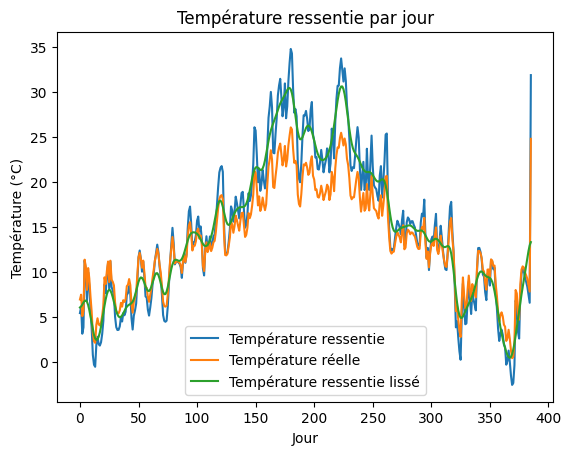

In [68]:
# ====== Calcule de la température ressentie par jour ======

apparent_temperature = []
for i in range(len(temperature)):
    apparent_temperature.append(ressentie(temperature[i], humidity[i], wind_speed[i]))
apparent_temperature = np.array(apparent_temperature)

# Smooth
smoothed_apparent_temperature = smooth_gausian(apparent_temperature, radius)

# Plot apparent temperature
plt.figure()
plt.plot(apparent_temperature, label='Température ressentie')
plt.plot(temperature, label='Température réelle')
plt.plot(smoothed_apparent_temperature, label='Température ressentie lissé')
plt.xlabel("Jour")
plt.ylabel("Température (°C)")
plt.title("Température ressentie par jour")
plt.legend()
plt.show()

### 4.2 Tests de corrélations

Nous allons tester ici la corrélation avec la température ressentie plutôt que la température brute pour voir s'il y'a une plus forte corrélation.

In [69]:
x_clean, y_clean = apparent_temperature[:360], consumption[:360]
x_clean.shape, y_clean.shape

((360,), (360,))

In [70]:
# ====== Calcule des coéficients ======

pearson_corr, pearson_p = sp.stats.pearsonr(x_clean, y_clean)
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4g}")

spearman_corr, spearman_p = sp.stats.spearmanr(x_clean, y_clean)
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4g}")

kendalltau_corr, kendalltau_p = sp.stats.kendalltau(x_clean, y_clean)
print(f"Kendall Tau correlation: {kendalltau_corr:.4f}, p-value: {kendalltau_p:.4g}")

Pearson correlation: -0.7715, p-value: 2.698e-72
Spearman correlation: -0.7984, p-value: 7.353e-81
Kendall Tau correlation: -0.5998, p-value: 1.001e-64


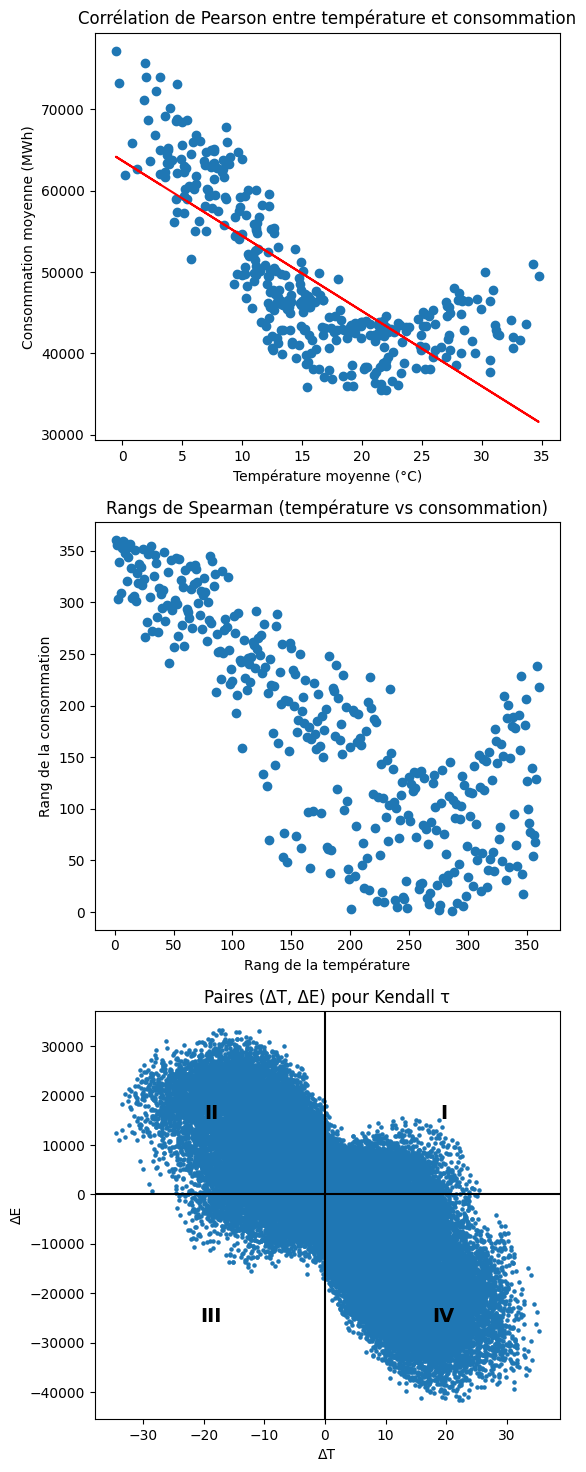

In [71]:
# Create subplots

fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# ====== Pearson ======

coef = np.polyfit(x_clean, y_clean, 1)
poly = np.poly1d(coef)

axs[0].scatter(x_clean, y_clean)
axs[0].plot(x_clean, poly(x_clean), color='red')
axs[0].set_xlabel("Température moyenne (°C)")
axs[0].set_ylabel("Consommation moyenne (MWh)")
axs[0].set_title("Corrélation de Pearson entre température et consommation")

# ====== Spearman ======

x_rank = rankdata(x_clean)
y_rank = rankdata(y_clean)

axs[1].scatter(x_rank, y_rank)
axs[1].set_xlabel("Rang de la température")
axs[1].set_ylabel("Rang de la consommation")
axs[1].set_title("Rangs de Spearman (température vs consommation)")

# ====== Kendall-thau ======

dT = []
dE = []

n = len(x_clean)
for i in range(n):
    for j in range(i+1, n):
        dT.append(x_clean[j] - x_clean[i])
        dE.append(y_clean[j] - y_clean[i])

dT = np.array(dT)
dE = np.array(dE)

axs[2].scatter(dT, dE, s=5)
axs[2].axhline(0, color='black')
axs[2].axvline(0, color='black')
axs[2].set_xlabel("ΔT")
axs[2].set_ylabel("ΔE")
axs[2].set_title("Paires (ΔT, ΔE) pour Kendall τ")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
xmid = (xmin + xmax) / 2
ymid = (ymin + ymax) / 2
axs[2].text((xmid + xmax)/2, (ymid + ymax)/2, 'I', fontsize=14, weight='bold', ha='center', va='center')
axs[2].text((xmin + xmid)/2, (ymid + ymax)/2, 'II', fontsize=14, weight='bold', ha='center', va='center')
axs[2].text((xmin + xmid)/2, (ymin + ymid)/2, 'III', fontsize=14, weight='bold', ha='center', va='center')
axs[2].text((xmid + xmax)/2, (ymin + ymid)/2, 'IV', fontsize=14, weight='bold', ha='center', va='center')

plt.show()

### 4.3 Conclusion

Les trois tests de corrélation (Pearson, Spearman et Kendall $\tau$) indiquent tous une **forte corrélation négative** entre la température ressentie hebdomadaire et la consommation électrique hebdomadaire en France en 2025, tous comme la corrélation entre la température réel et la consommation électrique.

Les valeurs des coefficients de corrélation sont :

- Pearson correlation: $-0.7734$, p-value: $7.182e^{-73}$
- Spearman correlation: $-0.7988$, p-value: $5.306e^{-81}$
- Kendall Tau correlation: $-0.5996$, p-value: $1.111e^{-64}$

Les valeurs des coefficients de corrélation qui concernent la tempéatures réelles sont :
- Pearson correlation: $-0.79$
- Spearman correlation: $-0.79$
- Kendall Tau correlation: $-0.59$

Nous pouvons conclure qu'il n'y a pas de changement significatif entre la température réelle et la température ressentie. Ainsi, **la température ressentie n'est pas d'avantage corrélée à la consommation électrique**.